In [27]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid,save_image
import torch.nn.functional as F
from tqdm.notebook import tqdm


In [2]:
DATA_DIR = 'animefacedataset'

In [3]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]

))

In [5]:
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [7]:
# class DeviceDataLoader:
#     def __init__(self,dl,device):
#         self.dl = dl
#         self.device = device
#     def __iter__(self):
#         for b in self.dl:
#             yield to_device(b.item,self.device)

In [8]:
for batch in train_dl:
    for data in batch:
        data.to(device)

In [9]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [10]:
discriminator = discriminator.to(device)

In [11]:
latent_size = 128

In [12]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [13]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

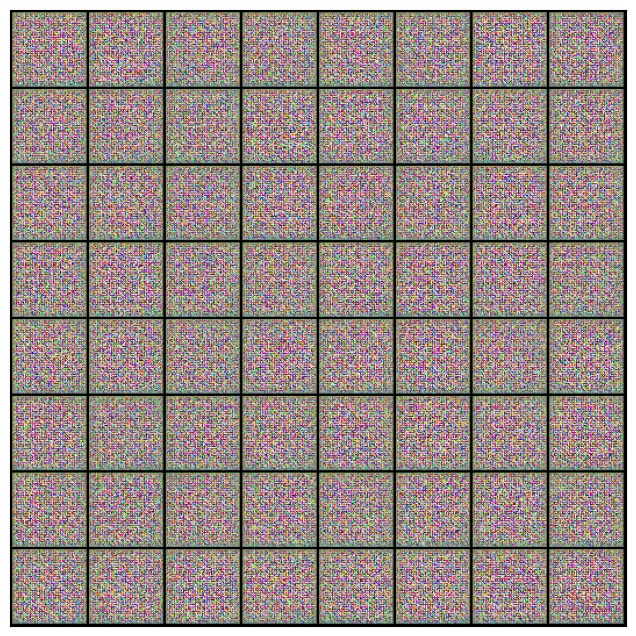

In [15]:
random_tensor = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(random_tensor)
show_images(fake_images)

In [16]:
generator = generator.to(device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [20]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [22]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


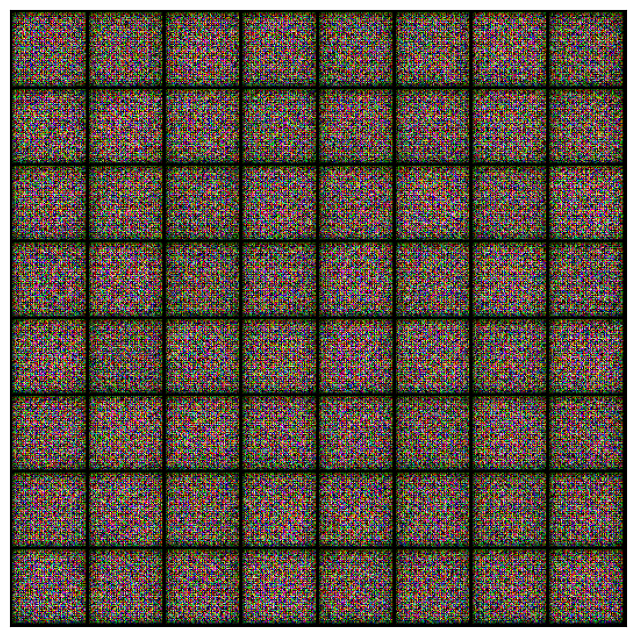

In [26]:
save_samples(0,fixed_latent)

In [45]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores    
    

In [50]:
lr = 0.0002
epochs = 30

In [52]:
history = fit(epochs,lr,start_idx=1)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 7.8822, loss_d: 0.0507, real_score: 0.9875, fake_score: 0.0354
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 6.0852, loss_d: 0.0335, real_score: 0.9836, fake_score: 0.0153
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 19.8751, loss_d: 0.1354, real_score: 0.9459, fake_score: 0.0225
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 16.8862, loss_d: 0.1741, real_score: 0.9932, fake_score: 0.1086
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 9.1627, loss_d: 0.1264, real_score: 0.9561, fake_score: 0.0679
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 9.4104, loss_d: 0.0149, real_score: 0.9890, fake_score: 0.0020
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 5.2073, loss_d: 0.0915, real_score: 0.9470, fake_score: 0.0179
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 6.5503, loss_d: 0.0213, real_score: 0.9905, fake_score: 0.0113
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 8.0171, loss_d: 0.1855, real_score: 0.8904, fake_score: 0.0009
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 6.9077, loss_d: 0.0463, real_score: 0.9850, fake_score: 0.0293
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 7.6480, loss_d: 0.0967, real_score: 0.9612, fake_score: 0.0213
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 7.6078, loss_d: 0.1127, real_score: 0.9269, fake_score: 0.0020
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 6.8623, loss_d: 0.0575, real_score: 0.9587, fake_score: 0.0022
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 6.1694, loss_d: 0.0654, real_score: 0.9670, fake_score: 0.0264
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 12.5478, loss_d: 0.0394, real_score: 0.9951, fake_score: 0.0321
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 8.2851, loss_d: 0.0374, real_score: 0.9745, fake_score: 0.0051
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 7.7561, loss_d: 0.0816, real_score: 0.9851, fake_score: 0.0616
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 7.0314, loss_d: 0.0188, real_score: 0.9863, fake_score: 0.0031
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 7.1467, loss_d: 0.0147, real_score: 0.9963, fake_score: 0.0107
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 6.8933, loss_d: 0.0888, real_score: 0.9741, fake_score: 0.0541
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 6.5976, loss_d: 0.0962, real_score: 0.9805, fake_score: 0.0597
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 5.0752, loss_d: 0.0347, real_score: 0.9759, fake_score: 0.0054
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 6.8821, loss_d: 0.0212, real_score: 0.9951, fake_score: 0.0160
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 7.6537, loss_d: 0.0269, real_score: 0.9856, fake_score: 0.0117
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 8.6201, loss_d: 0.0819, real_score: 0.9997, fake_score: 0.0707
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 23.7619, loss_d: 0.0010, real_score: 0.9994, fake_score: 0.0004
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 18.2255, loss_d: 0.0598, real_score: 0.9629, fake_score: 0.0000
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 6.5862, loss_d: 0.0169, real_score: 0.9922, fake_score: 0.0088
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 15.1502, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 32.4987, loss_d: 0.0427, real_score: 0.9992, fake_score: 0.0388
Saving generated-images-0030.png


In [35]:
import pickle

In [36]:
with open('generator','wb') as generator_file:
    pickle.dump(generator,generator_file)

In [39]:
with open('discriminator','wb') as discriminator_file:
    pickle.dump(discriminator, discriminator_file)

In [41]:
with open('generator','rb') as generator_file:
    generator1 = pickle.load(generator_file)
with open('discriminator','rb') as discriminator_file:
    discriminator1 = pickle.load(discriminator_file)